In [1]:
import numpy as np
from ARMA import ARMA
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sns
from sklearn.svm import SVC, OneClassSVM
from sklearn.metrics import confusion_matrix, classification_report, f1_score
import matplotlib.pyplot as plt

In [2]:
root = './data/Train/chb06'
cclass_a = 'Interictal'
cclass_b = 'Preictal'

interictal_files_training = ['chb06_02_interictal.npy', 'chb06_03_interictal.npy']
interictal_file_validation = 'chb06_05_interictal.npy'

preictal_files_training = ['chb01_03_preictal.npy', 'chb01_04_preictal.npy']
preictal_file_validation = 'chb01_15_preictal.npy'

In [3]:
# ARMA parameters
seed = 42
fs = 256                 # sampling frequency (Hz)
N = 512                  # fs = N*fp (N must be a natural number)
fp = fs/N                # prediction frequency
n_i = 2                  # AR model order
t_s = 1/fs               # Input signal time period
n_c = 23                 # Number of EEG electrodes (channels)
m = 30                   # MA parameter
print(f'Input channels: {n_c}')
print(f'Model: AR({n_i})')
print(f'MA lookback: {m}')
print(f'Window size: {N}')
print(f'Sampling frequency: {fs} Hz')
print(f'Prediction frequency: {fp} Hz')
ar = ARMA(window_width=N, order=n_i, memory=m, seed=seed)

Input channels: 23
Model: AR(2)
MA lookback: 30
Window size: 512
Sampling frequency: 256 Hz
Prediction frequency: 0.5 Hz


In [4]:
# generate TRAIN AR features
interictal_train_feature_list = []
preictal_train_feature_list = []
for i in range(2):
    # interictal
    filepath = root + '/' + cclass_a + '/' + interictal_files_training[i]
    data = np.load(filepath)
    _, _, features = ar.spin(sig=data, fs=256)
    interictal_train_feature_list.append(features[31:])
    # preictal
    filepath = root + '/' + cclass_b + '/' + preictal_files_training[i]
    data = np.load(filepath)
    _, _, features = ar.spin(sig=data, fs=256)
    preictal_train_feature_list.append(features[31:])
del filepath, data, features

100%|██████████| 229887/229887 [00:01<00:00, 131878.40it/s]


In [5]:
# generate VALIDATION AR features
# interictal
filepath = root + '/' + cclass_a + '/' + interictal_file_validation
data = np.load(filepath)
_, _, interictal_val = ar.spin(sig=data, fs=256)
interictal_val = interictal_val[31:]
# preictal
filepath = root + '/' + cclass_b + '/' + preictal_file_validation
data = np.load(filepath)
_, _, preictal_val = ar.spin(sig=data, fs=256)
preictal_val = preictal_val[31:]
del filepath, data

100%|██████████| 229887/229887 [00:01<00:00, 126167.92it/s]


In [6]:
print(interictal_train_feature_list[0].shape, preictal_train_feature_list[0].shape)
print(interictal_val.shape, preictal_val.shape)

(418, 2) (418, 2)
(418, 2) (418, 2)


In [7]:
interictal_train = np.vstack(interictal_train_feature_list)
preictal_train = np.vstack(preictal_train_feature_list)
print(interictal_train.shape, preictal_train.shape)

(836, 2) (836, 2)


In [8]:
# generate TRAIN labels
interictal_train_targets = -1 * np.ones(interictal_train.shape[0]) # interictal samples are labelled -1
preictal_train_targets = np.ones(preictal_train.shape[0]) # preictal samples are labelled 1
print(interictal_train_targets.shape, preictal_train_targets.shape)

(836,) (836,)


In [9]:
# generate VALIDATION labels
interictal_val_targets = -1 * np.ones(interictal_val.shape[0])
preictal_val_targets = np.ones(preictal_val.shape[0])
print(interictal_val_targets.shape, preictal_val_targets.shape)

(418,) (418,)


In [10]:
X = np.vstack((interictal_train, interictal_val, preictal_train, preictal_val))
y = np.hstack((interictal_train_targets, interictal_val_targets, preictal_train_targets, preictal_val_targets))
print(X.shape, y.shape)

(2508, 2) (2508,)


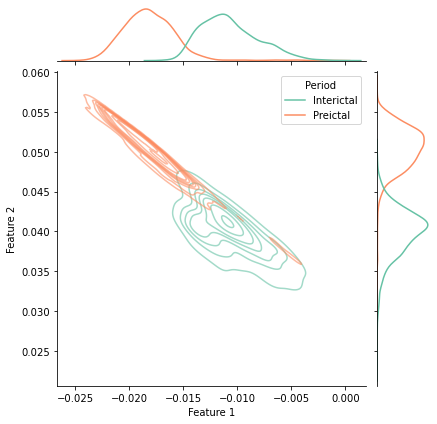

In [11]:
# visualise
df = pd.DataFrame(X, columns=['Feature 1', 'Feature 2'])
df['Period'] = y
di = {-1: "Interictal", 1: "Preictal"} # map numeric target to string label
df.replace({"Period": di}, inplace=True)
palette = sns.color_palette('Set2', n_colors=2)
sns.jointplot(data=df, x='Feature 1', y='Feature 2', hue='Period', kind='kde', palette=palette, alpha=0.6)

In [12]:
# shuffle and split into TRAIN and VAL sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=42)
print(X_train.shape, X_val.shape)

(1680, 2) (828, 2)


[[409   0]
 [419   0]]
              precision    recall  f1-score   support

        -1.0       0.49      1.00      0.66       409
         1.0       0.00      0.00      0.00       419

    accuracy                           0.49       828
   macro avg       0.25      0.50      0.33       828
weighted avg       0.24      0.49      0.33       828



/Users/sameenislam/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


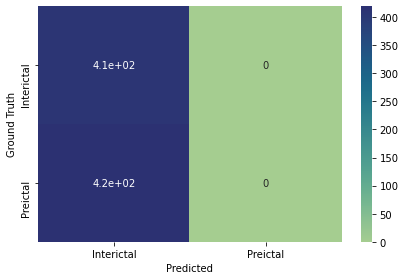

In [13]:
# model training
svc = SVC(kernel='linear', class_weight='balanced')
svc.fit(X_train, y_train)

y_pred = svc.predict(X_val)
print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))
confuse = confusion_matrix(y_val, y_pred)

palette = sns.color_palette('crest', as_cmap=True)
ax = sns.heatmap(confuse, annot=True, cmap=palette)
ax.set_xticklabels(["Interictal", "Preictal"])
ax.set_yticklabels(["Interictal", "Preictal"])
ax.set_xlabel('Predicted')
ax.set_ylabel('Ground Truth')
plt.tight_layout()

The linear SVM performed worse than a random predictor as its F1 score was below 0.5

[[  1 408]
 [  9 410]]
              precision    recall  f1-score   support

        -1.0       0.10      0.00      0.00       409
         1.0       0.50      0.98      0.66       419

    accuracy                           0.50       828
   macro avg       0.30      0.49      0.33       828
weighted avg       0.30      0.50      0.34       828



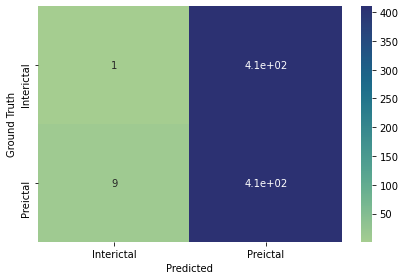

In [14]:
# OneClassSVM is an outlier detection model
model = OneClassSVM(gamma='auto', nu=0.01)
model.fit(X_train)

y_pred = model.predict(X_val)
print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))
confuse = confusion_matrix(y_val, y_pred)

palette = sns.color_palette('crest', as_cmap=True)
ax = sns.heatmap(confuse, annot=True, cmap=palette)
ax.set_xticklabels(["Interictal", "Preictal"])
ax.set_yticklabels(["Interictal", "Preictal"])
ax.set_xlabel('Predicted')
ax.set_ylabel('Ground Truth')
plt.tight_layout()

[[400   9]
 [ 19 400]]
              precision    recall  f1-score   support

        -1.0       0.95      0.98      0.97       409
         1.0       0.98      0.95      0.97       419

    accuracy                           0.97       828
   macro avg       0.97      0.97      0.97       828
weighted avg       0.97      0.97      0.97       828



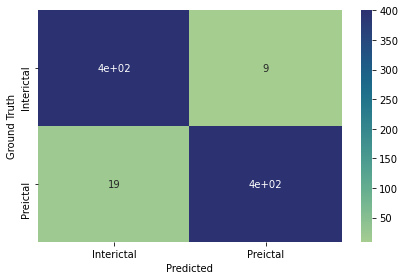

In [15]:
# model training
svc = SVC(kernel='rbf', class_weight='balanced')
svc.fit(X_train, y_train)

y_pred = svc.predict(X_val)
print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))
confuse = confusion_matrix(y_val, y_pred)

palette = sns.color_palette('crest', as_cmap=True)
ax = sns.heatmap(confuse, annot=True, cmap=palette)
ax.set_xticklabels(["Interictal", "Preictal"])
ax.set_yticklabels(["Interictal", "Preictal"])
ax.set_xlabel('Predicted')
ax.set_ylabel('Ground Truth')
plt.tight_layout()